## Observations:
zip is available in address - index on split is -1, -5:

potential interests:
- zip code (reduced to large(-ish?) sample sizes)
- maybe look at geographical location specifically? (Is proximity to city center and features calculable?| $\checkmark$)
  - look into part 2 ^
  - waterfront is listed as a binary column
- (person pref, focus on home buyers/individuals)
- someone mentioned school data - this isn't a bad idea.
  - can get school rankings and their zip codes

would like to get external/additional information. Will check Kaggle for related data sets

https://kingcounty.gov/ <= city website

find out if prices are based on closes or valuations - if closes, can 

### Data cleaning
- multiple y/n / cat. columns that can be converted to dummies for OLS discovery
- view quality can be rated as good/bad/avg. , could be extrapolated to 0-2 (more if more options there)
- grade?

<hr/>
Data from [column_names.md](data/column_names.md)  
vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv

* `view` - Quality of view from house
  * Includes views of Mt. Rainier, Olympics, Cascades, Territorial, Seattle Skyline, Puget Sound, Lake Washington, Lake Sammamish, small lake / river / creek, and other
* `condition` - How good the overall condition of the house is. Related to maintenance of house.
  * See the [King County Assessor Website](https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r) for further explanation of each condition code
* `grade` - Overall grade of the house. Related to the construction and design of the house.
  * See the [King County Assessor Website](https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r) for further explanation of each building grade code
<hr/>

lots of relevant info for discovery in there

# _*IMPORTANT*_

Most fields were pulled from the [King County Assessor Data Download](https://info.kingcounty.gov/assessor/DataDownload/default.aspx).

The `address`, `lat`, and `long` fields have been retrieved using a third-party [geocoding API](https://docs.mapbox.com/api/search/geocoding/). In some cases due to missing or incorrectly-entered data from the King County Assessor, this API returned locations outside of King County, WA. If you plan to use the `address`, `lat`, or `long` fields in your modeling, consider identifying outliers prior to including the values in your model

<br/><hr/><br/><hr/>

excluding < 400sqft, tiny home by definition per:
"A dwelling unit that is 400 square feet (37 m2) or less in floor area excluding sleeping lofts"
src: https://www.seattle.gov/documents/Departments/SDCI/Codes/SeattleResidentialCode/2018SRCAppendixQ.pdf

### imports

In [153]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import statsmodels.api as sm

from code.features import has_feature

In [5]:
housing_df = pd.read_csv('data/kc_house_data.csv')
zip_codes = pd.read_csv('data/King_County_Zip_Codes.csv')

## ALL DF Definitions
merge these more cleanly in the index

bring in zip codes from _*ONLY*_ King County (data from: https://www.zip-codes.com/county/wa-king.asp) and take out any data outside of the county

In [113]:
# This is 1,000,000x more efficient than re-calling the geopy functions since this is available.

housing_df['zip'] = housing_df['address'].map(lambda x: x.split(',')[-2][-5:])
housing_df['town']= housing_df['address'].map(lambda x: x.split(',')[-3].strip())
kc_only = housing_df.merge(zip_codes['Zip Codes'].astype(str),left_on='zip',right_on='Zip Codes',how='inner')

In [114]:
display(kc_only.info(), kc_only.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29189 entries, 0 to 29188
Data columns (total 28 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             29189 non-null  int64  
 1   date           29189 non-null  object 
 2   price          29189 non-null  float64
 3   bedrooms       29189 non-null  int64  
 4   bathrooms      29189 non-null  float64
 5   sqft_living    29189 non-null  int64  
 6   sqft_lot       29189 non-null  int64  
 7   floors         29189 non-null  float64
 8   waterfront     29189 non-null  object 
 9   greenbelt      29189 non-null  object 
 10  nuisance       29189 non-null  object 
 11  view           29189 non-null  object 
 12  condition      29189 non-null  object 
 13  grade          29189 non-null  object 
 14  heat_source    29160 non-null  object 
 15  sewer_system   29176 non-null  object 
 16  sqft_above     29189 non-null  int64  
 17  sqft_basement  29189 non-null  int64  
 18  sqft_g

None

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,lat,long
count,2.918900e+04,2.918900e+04,29189.000000,29189.000000,29189.000000,2.918900e+04,29189.000000,29189.000000,29189.000000,29189.000000,29189.000000,29189.000000,29189.000000,29189.000000,29189.000000
mean,4.535750e+09,1.113059e+06,3.435335,2.331889,2130.911987,1.720745e+04,1.516564,1825.949844,480.890747,336.257666,216.342972,1973.827401,93.931344,47.543297,-122.214229
std,2.882323e+09,8.957550e+05,0.978759,0.896124,977.502626,6.131060e+04,0.548233,880.928042,586.056457,286.283099,246.810496,31.681435,422.974700,0.145975,0.143445
min,1.000055e+06,2.736000e+04,0.000000,0.000000,3.000000,4.020000e+02,1.000000,2.000000,0.000000,0.000000,0.000000,1900.000000,0.000000,47.155265,-122.526650
25%,2.085201e+09,6.450000e+05,3.000000,2.000000,1440.000000,5.000000e+03,1.000000,1190.000000,0.000000,0.000000,40.000000,1952.000000,0.000000,47.430940,-122.328435
50%,3.874000e+09,8.685000e+05,3.000000,2.500000,1940.000000,7.560000e+03,1.500000,1580.000000,0.000000,400.000000,140.000000,1976.000000,0.000000,47.557810,-122.233905
75%,7.287100e+09,1.310000e+06,4.000000,3.000000,2640.000000,1.078400e+04,2.000000,2290.000000,960.000000,510.000000,310.000000,2001.000000,0.000000,47.672005,-122.127477
max,9.904000e+09,3.075000e+07,13.000000,10.500000,15360.000000,3.253932e+06,4.000000,12660.000000,8020.000000,3580.000000,4370.000000,2022.000000,2022.000000,47.789830,-121.163960


reduce df down to only houses that are not legally considered tiny homes, have bedrooms, and have at least a half-bath  
also, remove the lat and long columns - they are not being used  
<sub>come back to this later to clean data for visibility if necessary</sub>

output to homes_df variable

convert features from sqft to binary have/have-not column  
because this is in 1 and 0, this doesn't need to be dummied and dropped

In [115]:
kc_only['has_basement'] = kc_only['sqft_basement'].map(has_feature)
kc_only['has_garage'] = kc_only['sqft_garage'].map(has_feature)
kc_only['has_patio'] = kc_only['sqft_patio'].map(has_feature)
kc_only.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,...,yr_renovated,address,lat,long,zip,town,Zip Codes,has_basement,has_garage,has_patio
0,7399300360,5/24/2022,675000.0,4,1.0,1180,7140,1.0,NO,NO,...,0,"2102 Southeast 21st Court, Renton, Washington ...",47.461975,-122.19052,98055,Renton,98055,0,0,1
1,3340401570,3/2/2022,750000.0,3,2.0,1830,7969,1.0,NO,NO,...,2008,"306 South 15th Street, Renton, Washington 9805...",47.466730,-122.21400,98055,Renton,98055,1,1,1
2,7399301200,3/29/2022,728000.0,4,2.0,2170,7520,1.0,NO,NO,...,0,"1814 Aberdeen Avenue Southeast, Renton, Washin...",47.463930,-122.18974,98055,Renton,98055,1,1,1
3,9899200050,3/24/2022,565000.0,4,2.0,1400,10364,1.5,NO,NO,...,0,"3426 Shattuck Avenue South, Renton, Washington...",47.448450,-122.21243,98055,Renton,98055,0,1,1
4,6673070070,12/28/2021,645000.0,3,2.0,1520,8250,1.0,NO,NO,...,0,"2209 Southeast 21st Street, Renton, Washington...",47.460870,-122.18869,98055,Renton,98055,1,1,1


In [116]:
homes_df = kc_only[(kc_only['sqft_living'] > 400) &
    (kc_only['bedrooms'] > 0) &
    (kc_only['bathrooms'] > 0)
    ].drop(['lat','long'],axis=1)

In [36]:
homes_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29121 entries, 0 to 29188
Data columns (total 28 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             29121 non-null  int64  
 1   date           29121 non-null  object 
 2   price          29121 non-null  float64
 3   bedrooms       29121 non-null  int64  
 4   bathrooms      29121 non-null  float64
 5   sqft_living    29121 non-null  int64  
 6   sqft_lot       29121 non-null  int64  
 7   floors         29121 non-null  float64
 8   waterfront     29121 non-null  object 
 9   greenbelt      29121 non-null  object 
 10  nuisance       29121 non-null  object 
 11  view           29121 non-null  object 
 12  condition      29121 non-null  object 
 13  grade          29121 non-null  object 
 14  heat_source    29101 non-null  object 
 15  sewer_system   29110 non-null  object 
 16  sqft_above     29121 non-null  int64  
 17  sqft_basement  29121 non-null  int64  
 18  sqft_g

In [51]:
sns.set()

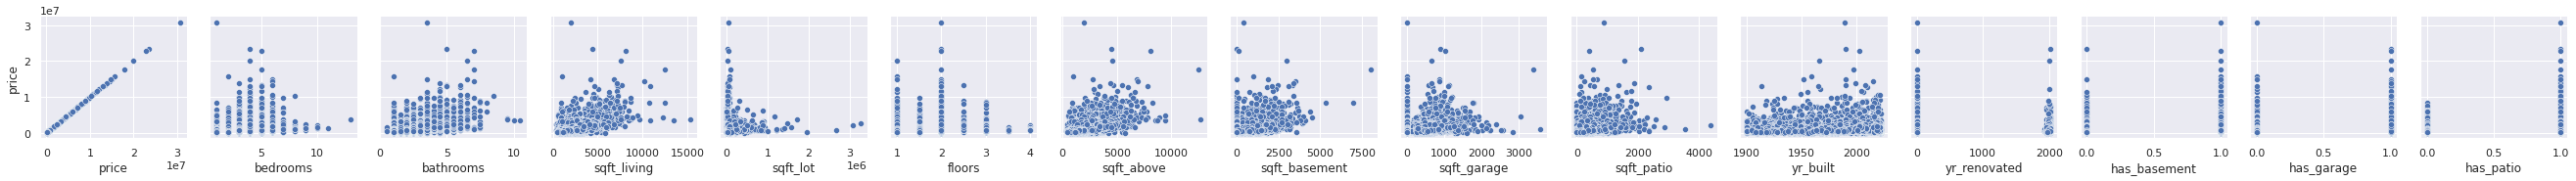

In [53]:
#fig, ax = plt.subplots()
sns.PairGrid(homes_df.iloc[:,2:],y_vars='price').map(sns.scatterplot)
'';

In [72]:
homes_df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'greenbelt', 'nuisance', 'view',
       'condition', 'grade', 'heat_source', 'sewer_system', 'sqft_above',
       'sqft_basement', 'sqft_garage', 'sqft_patio', 'yr_built',
       'yr_renovated', 'address', 'zip', 'Zip Codes', 'has_basement',
       'has_garage', 'has_patio'],
      dtype='object')

In [117]:
# this is a list of all of the columns in the dataframe
X_vals = [
#    'id',              # mostly useless
#    'date',            # not useful here' may be later
#    'price',           # this is y-val, needs dropped to avoid collinearity
    'bedrooms',
    'bathrooms',
    'sqft_living',
    'sqft_lot',
    'floors',
#    'waterfront',      # dummy
#    'greenbelt',       # dummy
#    'nuisance',        # dummy
#    'view',            # needs dummied
#    'condition',       # would need to be dummied out
#    'grade',           # not in a format we can use yet. May fix this.
#    'heat_source',     # dummy
#    'sewer_system',    # dummy
    'sqft_above',
#    'sqft_basement',   # already have the has_xyz columns, may switch back to these
#    'sqft_garage',     # ^
#    'sqft_patio',      # ^
    'yr_built',
    'yr_renovated',
#    'address',         # not numerical, little data is here - may be useful if we do a mapping function
#    'zip',             # may make this into a cat. column/dummy column later, lots of cats though... (76)
#    'town',            # dummy
#    'Zip Codes',       # <= only need/want 1 zip code column
    'has_basement',
    'has_garage',
    'has_patio'
]
X_vals

['bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'sqft_above',
 'yr_built',
 'yr_renovated',
 'has_basement',
 'has_garage',
 'has_patio']

In [120]:
homes_df.value_counts('zip')

zip
98042    991
98038    857
98103    758
98115    755
98117    743
        ... 
98051     67
98039     59
98288     18
98224      4
98050      2
Length: 76, dtype: int64

In [121]:
homes_df.value_counts('town')

town
Seattle                    9340
Renton                     1945
Kent                       1582
Auburn                     1509
Bellevue                   1482
Kirkland                   1270
Federal Way                1166
Redmond                     985
Sammamish                   977
Maple Valley                887
Shoreline                   796
Burien                      613
Woodinville                 588
Issaquah                    563
Covington                   501
North Bend                  468
Enumclaw                    455
Des Moines                  422
Mercer Island               348
Kenmore                     346
Snoqualmie                  289
Black Diamond               278
Bothell                     264
SeaTac                      253
Duvall                      246
Lake Forest Park            218
Vashon                      192
Newcastle                   187
Tukwila                     178
Carnation                   159
Normandy Park               112
Fal

In [82]:
homes_df[X_vals]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,heat_source,sewer_system,sqft_above,yr_built,yr_renovated,zip,has_basement,has_garage,has_patio
0,675000.0,4,1.0,1180,7140,1.0,Gas,PUBLIC,1180,1969,0,98055,0,0,1
1,750000.0,3,2.0,1830,7969,1.0,Gas,PUBLIC,930,1950,2008,98055,1,1,1
2,728000.0,4,2.0,2170,7520,1.0,Gas,PUBLIC,1240,1973,0,98055,1,1,1
3,565000.0,4,2.0,1400,10364,1.5,Electricity,PUBLIC,1400,1971,0,98055,0,1,1
4,645000.0,3,2.0,1520,8250,1.0,Gas,PUBLIC,1190,1981,0,98055,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29184,750000.0,3,1.0,1530,33250,1.5,Oil,PRIVATE,1530,1904,0,98050,1,0,1
29185,315000.0,1,1.0,480,7475,1.0,Electricity,PRIVATE,480,1908,1970,98224,0,0,0
29186,250000.0,2,1.0,1040,114998,1.0,Electricity,PRIVATE,1040,1928,0,98224,0,0,0
29187,202000.0,2,1.0,1260,11160,1.5,NaN,PRIVATE,1260,1918,0,98224,0,0,1


In [93]:
y = homes_df['price']
X = sm.add_constant(homes_df[X_vals])
print(sm.OLS(y,
    X).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.424
Model:                            OLS   Adj. R-squared:                  0.424
Method:                 Least Squares   F-statistic:                     1947.
Date:                Mon, 27 Mar 2023   Prob (F-statistic):               0.00
Time:                        16:06:40   Log-Likelihood:            -4.3232e+05
No. Observations:               29121   AIC:                         8.647e+05
Df Residuals:                   29109   BIC:                         8.648e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         6.827e+06   3.63e+05     18.788   

### Getting OLS for houses by zip code

In [105]:
X = sm.add_constant(
pd.get_dummies(homes_df['zip']).drop(
    homes_df['zip'].value_counts().index[0],axis=1
    ))

print(
    sm.OLS(y,
    X).fit().summary()
)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.382
Model:                            OLS   Adj. R-squared:                  0.381
Method:                 Least Squares   F-statistic:                     239.8
Date:                Mon, 27 Mar 2023   Prob (F-statistic):               0.00
Time:                        16:17:02   Log-Likelihood:            -4.3333e+05
No. Observations:               29121   AIC:                         8.668e+05
Df Residuals:                   29045   BIC:                         8.674e+05
Df Model:                          75                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.697e+05   2.23e+04     30.005      0.0

adj R<sup>2</sup> >0.38 - worth investigation  
several zips with P>|t| < 0.05, shows significance of those zips vs. base zip (most common)  
high abs(coef) in several cases as well, some high std.er, t stat varies

In [184]:
zip_by_price_mean = homes_df[
    ['zip','price']].groupby(by='zip').agg(
        {'price':'median','zip':'size'}
        ).rename(
            columns={'zip':'count'}
        ).reset_index().sort_values('price',ascending=False)
zip_by_price_mean

,zip,price,count
24,98039,4200000.0,59
3,98004,3100000.0,322
25,98040,2384500.0,348
4,98005,1962000.0,179
21,98033,1850000.0,607
...,...,...,...
68,98168,540000.0,383
28,98047,500000.0,77
1,98002,470000.0,364
75,98288,370000.0,18


In [185]:
zip_by_price_mean.sort_values(by='count')

,zip,price,count
29,98050,1600500.0,2
74,98224,226000.0,4
75,98288,370000.0,18
24,98039,4200000.0,59
30,98051,849950.0,67
...,...,...,...
55,98117,975000.0,743
53,98115,1030000.0,755
46,98103,945500.0,758
23,98038,770000.0,857


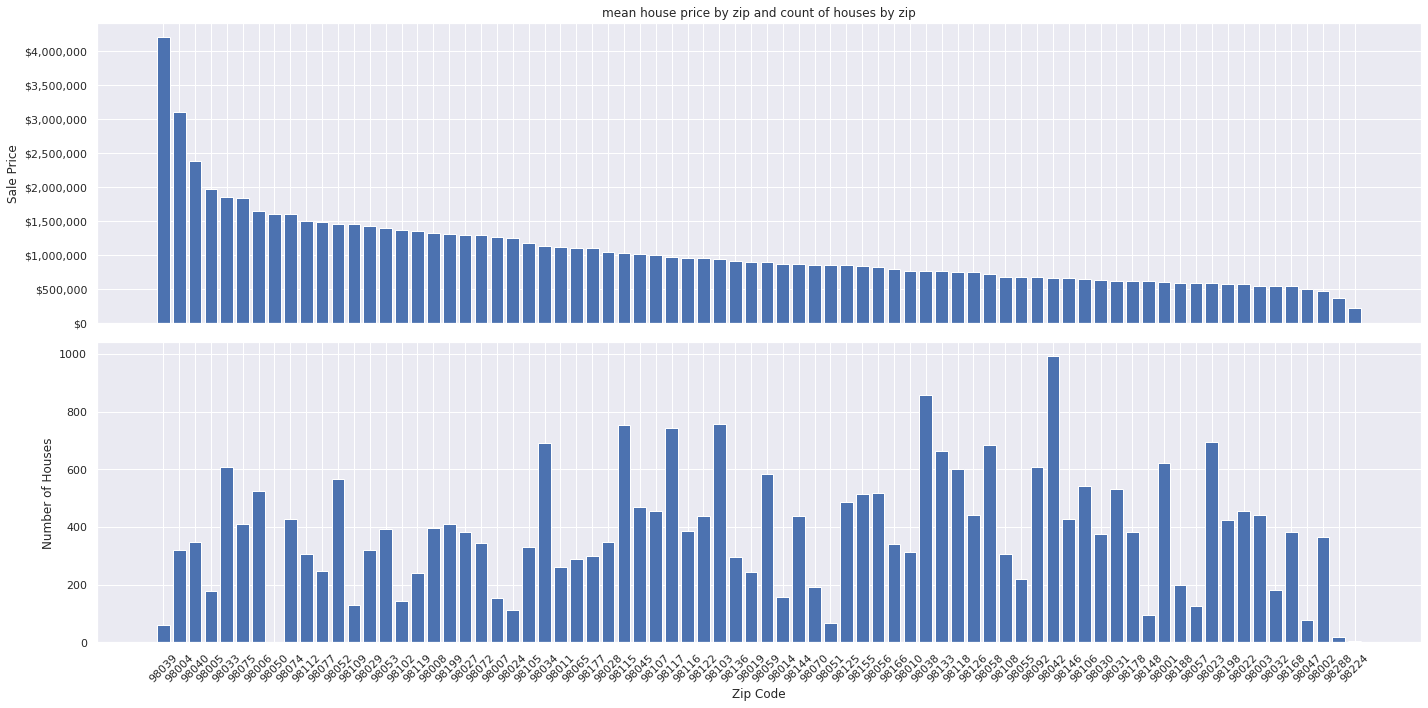

In [186]:
fig, ax = plt.subplots(2,1, sharex=True, figsize=(20,10))

y=[zip_by_price_mean['price'],zip_by_price_mean['count']]
x = zip_by_price_mean['zip']
ax[0].bar(x=x, height=y[0])
ax[1].bar(x=x, height=y[1])

ax[0].set(
    title='mean house price by zip and count of houses by zip',
    ylabel='Sale Price'
)
ax[1].set(
    ylabel='Number of Houses',
    xlabel='Zip Code',
)

dollar_format = mtick.StrMethodFormatter('${x:,.0f}')
ax[0].yaxis.set_major_formatter(dollar_format)
plt.xticks(rotation=45)
plt.tight_layout()
'';


In [187]:
zip_200 = zip_by_price_mean[zip_by_price_mean['count'] >= 200]
zip_200

,zip,price,count
3,98004,3100000.0,322
25,98040,2384500.0,348
21,98033,1850000.0,607
42,98075,1831000.0,411
5,98006,1650000.0,525
41,98074,1600000.0,428
52,98112,1500000.0,307
43,98077,1477500.0,246
31,98052,1460000.0,568
17,98029,1420000.0,321


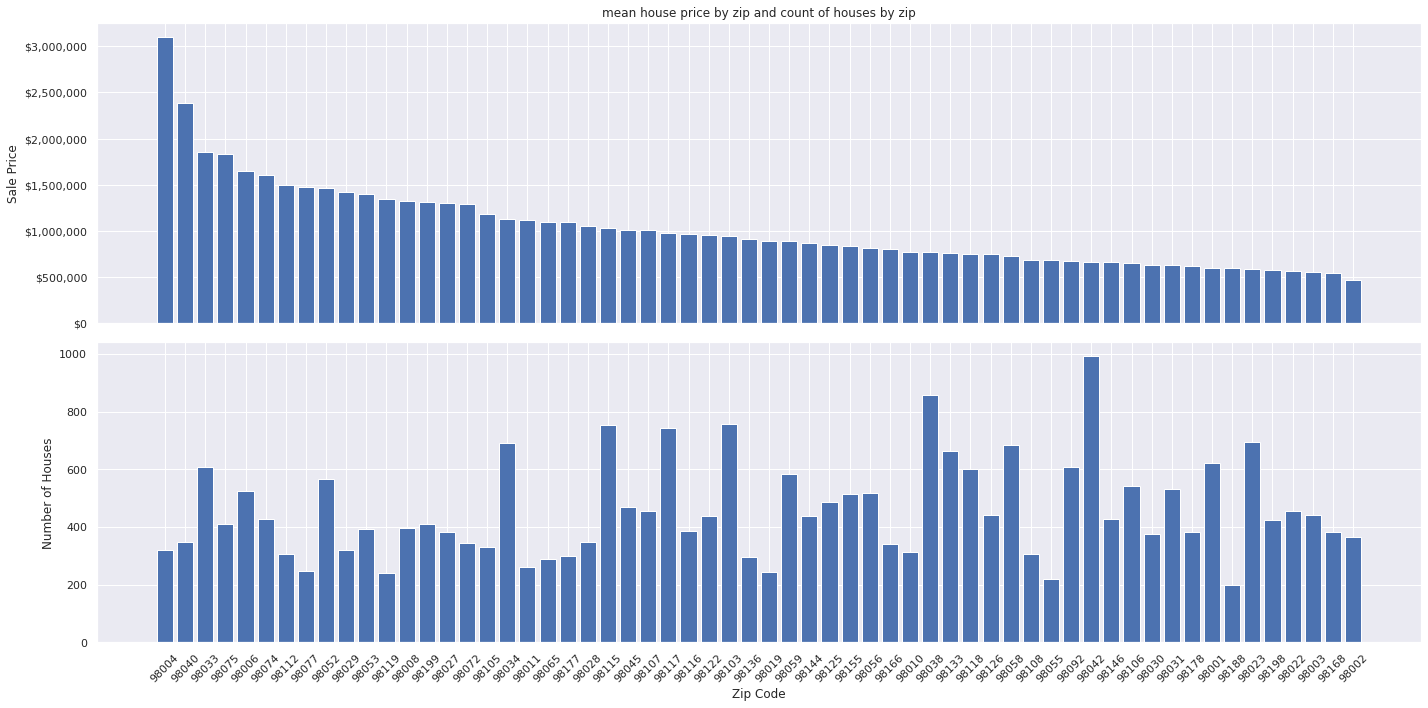

In [188]:
fig, ax = plt.subplots(2,1, sharex=True, figsize=(20,10))

y=[zip_200['price'],zip_200['count']]
x = zip_200['zip']
ax[0].bar(x=x, height=y[0])
ax[1].bar(x=x, height=y[1])

ax[0].set(
    title='mean house price by zip and count of houses by zip',
    ylabel='Sale Price'
)
ax[1].set(
    ylabel='Number of Houses',
    xlabel='Zip Code',
)

dollar_format = mtick.StrMethodFormatter('${x:,.0f}')
ax[0].yaxis.set_major_formatter(dollar_format)
plt.xticks(rotation=45)
plt.tight_layout()
'';


In [152]:
homes_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29121 entries, 0 to 29188
Data columns (total 29 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             29121 non-null  int64  
 1   date           29121 non-null  object 
 2   price          29121 non-null  float64
 3   bedrooms       29121 non-null  int64  
 4   bathrooms      29121 non-null  float64
 5   sqft_living    29121 non-null  int64  
 6   sqft_lot       29121 non-null  int64  
 7   floors         29121 non-null  float64
 8   waterfront     29121 non-null  object 
 9   greenbelt      29121 non-null  object 
 10  nuisance       29121 non-null  object 
 11  view           29121 non-null  object 
 12  condition      29121 non-null  object 
 13  grade          29121 non-null  object 
 14  heat_source    29101 non-null  object 
 15  sewer_system   29110 non-null  object 
 16  sqft_above     29121 non-null  int64  
 17  sqft_basement  29121 non-null  int64  
 18  sqft_g

In [206]:
pd.set_option('display.max_rows',None)
homes_df[['town','zip','price']].sort_values('price',ascending=False).groupby(by=['town','zip']).agg('median')

price
town                    zip             
Algona                  98001   450000.0
Ames Lake               98014  1420000.0
Auburn                  98001   610000.0
                        98002   470000.0
                        98003   709000.0
                        98092   675000.0
Baring                  98224   226000.0
Beaux Arts              98004  2100000.0
Bellevue                98004  2773000.0
                        98005  1962000.0
                        98006  1650000.0
                        98007  1260000.0
                        98008  1320000.0
Black Diamond           98010   745868.0
Bothell                 98011  1112500.0
                        98028  1335537.0
Burien                  98146   630000.0
                        98148   655000.0
                        98166   725000.0
                        98168   525000.0
Carnation               98014   867000.0
                        98053  1531500.0
Clyde Hill              98004  4150000.0
Cottage Lake            98072  1650000.0
Covington               98042   626187.0
Des Moines              98148   565000.0
                        98198   580000.0
Dilworth                98070   985000.0
Duvall                  98019   895000.0
                        98109  1181000.0
Enumclaw                98022   567230.0
                        98092  2225000.0
Fairwood                98058   755000.0
Fall City               98024  1250000.0
Federal Way             98001   670000.0
                        98003   550000.0
                        98023   590000.0
Hobart                  98038  1061250.0
Hunts Point             98004  7400000.0
Issaquah                98027  1294000.5
                        98029  1587500.0
                        98050   750000.0
Kenmore                 98028  1043000.0
Kent                    98030   630000.0
                        98031   625500.0
                        98032   549950.0
                        98042   690000.0
                        98058   758700.0
                        98059   507275.0
Kirkland                98033  1850000.0
                        98034  1125000.0
Lake Forest Park        98155  1000000.0
Lakeland North          98001   750000.0
Maple Valley            98010   962450.0
                        98038   770000.0
Medina                  98039  4200000.0
Mercer Island           98040  2384500.0
Milton                  98003   551000.0
Newcastle               98056  1218000.0
                        98059  1825000.0
Normandy Park           98148   362500.0
                        98166   985000.0
                        98198   850000.0
North Bend              98045  1008478.0
                        98065  1300000.0
Pacific                 98047   500000.0
Preston                 98024  1505250.0
                        98027  2150000.0
                        98050  2451000.0
Ravensdale              98051   849950.0
Redmond                 98033  1800000.0
                        98052  1460000.0
                        98053  1397000.0
                        98074  2350000.0
Renton                  98038  1037475.0
                        98042   600000.0
                        98055   679988.0
                        98056   750000.0
                        98057   593000.0
                        98058   726000.0
                        98059   850000.0
                        98178   800000.0
Sammamish               98029  1350000.0
                        98074  1600000.0
                        98075  1831000.0
SeaTac                  98148   825000.0
                        98168   536250.0
                        98188   575000.0
                        98198   499500.0
Seattle                 98102  1372187.5
                        98103   945500.0
                        98105  1182500.0
                        98106   650000.0
                        98107  1005500.0
                        98108   680000.0
                        98109  1455000.0
                 

<hr/>

<hr/>

## get_zip(s)() block

define zipcode lookup functions, may not be useful or used - keep for reference

In [4]:
# TODO: ##################################
# move this to code/ if it proves useful #
##########################################

import geopy # <= `conda install -c conda-forge geopy`

def get_zip(
    latitude,
    longitude,
    return_errors=False
    ):
    """_summary_

    Args:
        latitude (float): the latitude of a target address
        longitude (float): the longitude of a target address
        return_errors (bool): whether to return errors or None, useful for "dirty" data. Defaults to False.

    Returns:
        str: string zip/post code of the requested long/lat
    """
    geoloc = geopy.Nominatim(user_agent='check_1')
    try:
        location = geoloc.reverse(f"{latitude},{longitude}")
        return location.raw['address']['postcode']
    except:
        return ValueError() if return_errors else None

def get_zips(
    latitudes,
    longitudes,
    return_errors=False
    ):
    """_summary_

    Args:
        latitude (list): the latitudes of a target address. Should be a list of floats.
        longitude (list): the longitudes of a target address. Should be a list of floats.
        return_errors (bool, optional): whether to return errors or None, useful for "dirty" data. Defaults to False.

    Returns:
        list: list of zip codes (str) based on latitude and longitude provided
    """
    try:
        if len(latitudes) == len(longitudes):
            location = [get_zip(_lat, _long, return_errors) for (_lat,_long) in zip(latitudes,longitudes)]
            return location
    except:
        if return_errors:
            raise ValueError(f'Error(s) raised in thread: {Exception}')
        else:
            return None

In [5]:
# display(
#     housing_df[['lat','long']],
#     housing_df[['lat','long']].info()
#     )

In [6]:
# get_zip(47.449490, -122.18908)

In [7]:
# get_zips(
#     list(housing_df['lat'])[:10],
#     list(housing_df['long'])[:10],
#     True
#     )

In [8]:
# ofst = 150
# z = ofst + 0
# slc = ofst + 100
# get_zips(
#     list(housing_df['lat'])[z:slc],
#     list(housing_df['long'])[z:slc],
#     return_errors = False
#     )

<hr/>

In [24]:
housing_df.iloc[:,-4:].head()

,address,lat,long,zip
0,"2102 Southeast 21st Court, Renton, Washington ...",47.461975,-122.19052,98055
1,"11231 Greenwood Avenue North, Seattle, Washing...",47.711525,-122.35591,98133
2,"8504 South 113th Street, Seattle, Washington 9...",47.502045,-122.22520,98178
3,"4079 Letitia Avenue South, Seattle, Washington...",47.566110,-122.29020,98118
4,"2193 Northwest Talus Drive, Issaquah, Washingt...",47.532470,-122.07188,98027


In [8]:
housing_df['zip'].value_counts()

98042    992
98038    858
98115    761
98103    761
98117    748
        ... 
99202      1
56251      1
68347      1
47272      1
55912      1
Name: zip, Length: 399, dtype: int64

In [12]:
# get zip codes that have at least 100 entries

zip_counts = housing_df['zip'].value_counts().rename('zip_counts')

In [13]:
zips_counted = housing_df.merge(
    zip_counts,
    left_on='zip',
    right_index=True
)

In [14]:
zips_counted.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30155 entries, 0 to 29900
Data columns (total 27 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             30155 non-null  int64  
 1   date           30155 non-null  object 
 2   price          30155 non-null  float64
 3   bedrooms       30155 non-null  int64  
 4   bathrooms      30155 non-null  float64
 5   sqft_living    30155 non-null  int64  
 6   sqft_lot       30155 non-null  int64  
 7   floors         30155 non-null  float64
 8   waterfront     30155 non-null  object 
 9   greenbelt      30155 non-null  object 
 10  nuisance       30155 non-null  object 
 11  view           30155 non-null  object 
 12  condition      30155 non-null  object 
 13  grade          30155 non-null  object 
 14  heat_source    30123 non-null  object 
 15  sewer_system   30141 non-null  object 
 16  sqft_above     30155 non-null  int64  
 17  sqft_basement  30155 non-null  int64  
 18  sqft_g

In [15]:
zips_counted[zips_counted['zip_counts'] >= 100]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,...,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,address,lat,long,zip,zip_counts
0,7399300360,5/24/2022,675000.0,4,1.0,1180,7140,1.0,NO,NO,...,0,0,40,1969,0,"2102 Southeast 21st Court, Renton, Washington ...",47.461975,-122.190520,98055,219
40,3340401570,3/2/2022,750000.0,3,2.0,1830,7969,1.0,NO,NO,...,930,240,90,1950,2008,"306 South 15th Street, Renton, Washington 9805...",47.466730,-122.214000,98055,219
111,7399301200,3/29/2022,728000.0,4,2.0,2170,7520,1.0,NO,NO,...,1240,490,60,1973,0,"1814 Aberdeen Avenue Southeast, Renton, Washin...",47.463930,-122.189740,98055,219
229,9899200050,3/24/2022,565000.0,4,2.0,1400,10364,1.5,NO,NO,...,0,330,330,1971,0,"3426 Shattuck Avenue South, Renton, Washington...",47.448450,-122.212430,98055,219
308,6673070070,12/28/2021,645000.0,3,2.0,1520,8250,1.0,NO,NO,...,590,420,200,1981,0,"2209 Southeast 21st Street, Renton, Washington...",47.460870,-122.188690,98055,219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29809,723039050,12/16/2021,1826000.0,2,3.0,2070,71264,2.0,NO,NO,...,1360,480,952,2001,0,"10717 Southwest Biloxi Road, Vashon, Washingto...",47.504070,-122.471550,98070,195
29842,2022039037,4/14/2022,256000.0,2,1.0,1330,113815,1.0,NO,NO,...,0,280,0,1911,1962,"9632 Southwest Bayview Drive, Vashon, Washingt...",47.387960,-122.456440,98070,195
29913,2322039033,7/14/2021,950000.0,2,2.5,1960,11406,2.0,NO,NO,...,840,420,560,1938,1985,"4510 Southwest 244th Street, Vashon, Washingto...",47.386190,-122.387935,98070,195
29985,3023039221,9/21/2021,450000.0,2,2.0,840,138520,1.0,NO,NO,...,0,0,230,2020,0,"16097 109th Avenue Southwest, Vashon, Washingt...",47.458555,-122.475450,98070,195


In [9]:
housing_df[housing_df['yr_renovated'] >= 1990]['price'].mean()

1566095.078763709

In [17]:
housing_df['price'].mean()


1108535.837871

In [18]:
housing_df[housing_df['yr_renovated'] >= 1990]['price'].mean() -housing_df['price'].mean()

457559.240892709

In [11]:
kc_only['heat_source']

0                Gas
1                Gas
2                Gas
3        Electricity
4                Gas
            ...     
29184            Oil
29185    Electricity
29186    Electricity
29187            NaN
29188    Electricity
Name: heat_source, Length: 29189, dtype: object

In [26]:
heating_types = homes_df[['heat_source','price']].groupby(by='heat_source').agg('mean','count')
heating_types

,price
heat_source,
Electricity,9.014787e+05
Electricity/Solar,9.438324e+05
Gas,1.201102e+06
Gas/Solar,1.699729e+06
Oil,9.221385e+05
Oil/Solar,9.321750e+05
Other,1.147928e+06


In [23]:
display(homes_df.info(), homes_df.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29121 entries, 0 to 29188
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             29121 non-null  int64  
 1   date           29121 non-null  object 
 2   price          29121 non-null  float64
 3   bedrooms       29121 non-null  int64  
 4   bathrooms      29121 non-null  float64
 5   sqft_living    29121 non-null  int64  
 6   sqft_lot       29121 non-null  int64  
 7   floors         29121 non-null  float64
 8   waterfront     29121 non-null  object 
 9   greenbelt      29121 non-null  object 
 10  nuisance       29121 non-null  object 
 11  view           29121 non-null  object 
 12  condition      29121 non-null  object 
 13  grade          29121 non-null  object 
 14  heat_source    29101 non-null  object 
 15  sewer_system   29110 non-null  object 
 16  sqft_above     29121 non-null  int64  
 17  sqft_basement  29121 non-null  int64  
 18  sqft_g

None

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated
count,2.912100e+04,2.912100e+04,29121.000000,29121.000000,29121.000000,2.912100e+04,29121.000000,29121.000000,29121.000000,29121.000000,29121.000000,29121.000000,29121.000000
mean,4.535712e+09,1.113088e+06,3.442155,2.335737,2133.747193,1.714997e+04,1.516500,1828.018303,481.795955,336.882799,216.735517,1973.841661,93.875279
std,2.882808e+09,8.929574e+05,0.968757,0.892784,975.529983,6.088276e+04,0.547341,879.751316,586.174616,286.182431,246.921425,31.664982,422.852566
min,1.000055e+06,2.736000e+04,1.000000,0.500000,410.000000,4.020000e+02,1.000000,390.000000,0.000000,0.000000,0.000000,1900.000000,0.000000
25%,2.085201e+09,6.450000e+05,3.000000,2.000000,1440.000000,5.000000e+03,1.000000,1190.000000,0.000000,0.000000,40.000000,1952.000000,0.000000
50%,3.869900e+09,8.690000e+05,3.000000,2.500000,1950.000000,7.560000e+03,1.500000,1580.000000,0.000000,400.000000,145.000000,1976.000000,0.000000
75%,7.287100e+09,1.310000e+06,4.000000,3.000000,2640.000000,1.077600e+04,2.000000,2290.000000,960.000000,520.000000,310.000000,2001.000000,0.000000
max,9.904000e+09,3.075000e+07,13.000000,10.500000,15360.000000,3.253932e+06,4.000000,12660.000000,8020.000000,3580.000000,4370.000000,2022.000000,2022.000000


In [24]:
kc_only[kc_only['price'] >= 10000000].value_counts('zip')

zip
98004    8
98039    6
98040    3
98122    2
98112    2
98177    1
98105    1
98072    1
98059    1
98008    1
dtype: int64

In [25]:
kc_only[kc_only['price'] >= 10000000].sort_values('price', ascending=False)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,...,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,address,lat,long,zip,Zip Codes
20040,5026900270,11/4/2021,30750000.0,1,3.5,2040,50705,2.0,YES,NO,...,410,0,890,1989,0,"1620 Lake Washington Boulevard, Seattle, Washi...",47.615910,-122.280880,98122,98122
11568,3534900325,9/23/2021,23500000.0,4,5.0,4440,15494,2.0,YES,NO,...,0,900,2100,1990,2014,"4335 Hunts Point Road, Hunts Point, Washington...",47.650735,-122.230482,98004,98004
11788,624059038,9/23/2021,22750000.0,5,7.0,8160,32920,2.0,YES,NO,...,90,1020,400,2003,0,"2011 100th Avenue Northeast, Bellevue, Washing...",47.628725,-122.207360,98004,98004
9345,5427300046,9/27/2021,20000000.0,4,6.5,7610,28800,1.0,YES,NO,...,3010,660,1540,1966,2006,"605 Evergreen Point Road, Medina, Washington 9...",47.616095,-122.239600,98039,98039
27692,3304700355,12/12/2021,17800000.0,5,7.0,12470,92345,2.0,NO,NO,...,8020,3390,520,1997,0,"69 Olympic Drive, Shoreline, Washington 98177,...",47.741150,-122.374255,98177,98177
17739,3424059021,5/16/2022,15740000.0,2,1.0,1010,68824,1.0,NO,NO,...,1010,0,150,1959,0,"8430 138th Avenue Southeast, Newcastle, Washin...",47.526320,-122.156820,98059,98059
9315,9208900030,8/27/2021,15000001.0,6,6.5,6780,77594,2.0,YES,NO,...,0,880,660,1990,0,"2213 Evergreen Point Road, Medina, Washington ...",47.630835,-122.240600,98039,98039
25914,9471200795,10/29/2021,14850000.0,4,3.5,4240,67106,1.0,YES,NO,...,1880,0,520,1952,0,"5625 Northeast Ambleside Road, Seattle, Washin...",47.666120,-122.264660,98105,98105
9335,2470000040,8/31/2021,14500000.0,6,7.0,10250,32614,2.0,NO,NO,...,3530,860,250,2015,0,"1637 77th Avenue Northeast, Medina, Washington...",47.625780,-122.237750,98039,98039
18383,2424049035,8/19/2021,13950000.0,0,1.0,290,178017,1.0,YES,NO,...,0,0,160,1940,0,"5045 Forest Avenue Southeast, Mercer Island, W...",47.556910,-122.230600,98040,98040
